# Homework Assignment 3: Google PageRank

In this assignment we will explore how eigenvalues and eigenvectors are used by Google to rank web pages in their search engine. This so called PageRank algorithm (developed by Larry Page and Sergey Brin, the founders of Google) revolutionized web search. According to Google, PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites. 



In [ ]:
# All Import Statements Defined Here
# Note: Do not add to this list anywhere.
# ----------------

import math
import numpy as np
import numpy.linalg as la

## Problem 1: Adjoint matrix (2 points)

Implement the function `adjoint` below that computes the adjoint of a square matrix and returns it as an ndarray. The (i,j)-th element of the adjoint of a matrix $A$ can be computed by $$(\text{adj}(A))_{ij} = (-1)^{i+j} M_{ji},$$ where $M_{ji}$ is the determinant of the matrix that you get when you remove row $j$ and column $i$ from $A$ (called the $(j,i)$-minor of $B$).

*Hint: use the NumPy function [`delete`](https://numpy.org/doc/stable/reference/generated/numpy.delete.html) to remove removes/columns from your array. This does not alter the original array!*

In [175]:
def adjoint(A):
    """
    Computes the adjoint matrix of A, see definition in the problem statement.
    
    Parameters
    ----------
        A (ndarray): a square 2d array
        
    Returns
    -------
        adj (ndarray): a square 2d array of the same shape as A,
            that represents its adjoint matrix
        
    """
       
    # YOUR CODE HERE
    n = int(A.size**0.5)
    adj = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            M = np.delete(A, i, 0)
            M = np.delete(M, j, 1)
            mij = np.linalg.det(M)
            adj[j,i]=mij*(-1)**(i+j)
    return(adj)


In [176]:
# You can use this code cell to play around with your code to make sure
# it does what it is intended to do, i.e. to debug your code. 
A = np.array([[2, -3, 4],
              [0, 0, -1], 
              [1, -2, 1]])
n = int(A.size**0.5)
adj = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n):
        m = np.delete(A, i, 0)
        m = np.delete(m, j, 1)
        print("\n", m, i, j, "\n", np.linalg.det(m))
        adj[j, i]=np.linalg.det(m)*(-1)**(i+j)
print(adj, "\n")

adj = adjoint(A)
print(adj)


 [[ 0 -1]
 [-2  1]] 0 0 
 -2.0

 [[ 0 -1]
 [ 1  1]] 0 1 
 1.0

 [[ 0  0]
 [ 1 -2]] 0 2 
 0.0

 [[-3  4]
 [-2  1]] 1 0 
 5.000000000000001

 [[2 4]
 [1 1]] 1 1 
 -2.0

 [[ 2 -3]
 [ 1 -2]] 1 2 
 -1.0

 [[-3  4]
 [ 0 -1]] 2 0 
 3.0000000000000004

 [[ 2  4]
 [ 0 -1]] 2 1 
 -2.0

 [[ 2 -3]
 [ 0  0]] 2 2 
 0.0
[[-2. -5.  3.]
 [-1. -2.  2.]
 [ 0.  1.  0.]] 

[[-2. -5.  3.]
 [-1. -2.  2.]
 [ 0.  1.  0.]]


In [177]:
# Test case
A = np.array([[2, -3, 4],
              [0, 0, -1], 
              [1, -2, 1]])
adj = adjoint(A)
print(adj)

[[-2. -5.  3.]
 [-1. -2.  2.]
 [ 0.  1.  0.]]


Expected output:

    [[-2. -5.  3.]
     [-1. -2.  2.]
     [ 0.  1.  0.]]

In [178]:
# AUTOGRADING
A = np.array([[2, -3, 4],
              [0, 0, -1], 
              [1, -2, 1]])

assert np.allclose(adjoint(A), la.det(A) * la.inv(A))

B = np.arange(16).reshape((4,4))
assert np.allclose(adjoint(B), np.zeros((4,4)))

C = np.array([[-3, 2, -5], 
              [-1, 0, -2],
              [3, -4, 1]])

assert np.allclose(adjoint(C), la.det(C) * la.inv(C))

## Google PageRank

We consider the web to be a fixed set of pages, with each page containing a fixed set of *hyperlinks*, and each link is a reference to some other page. We will study what happens to a person (the web surfer) who randomly moves from page to page by clicking a link on the current page. To start simple, we will assume that the *surfer* has equal probability of clicking any link on its current page. The PageRank is the ranked order of the pages from the most to least probable page the surfer will be viewing.

In the code below, we generate a micro-internet with just 6 websites, represented as a `graph`. (Google in comparison has indexed over 50 billion web pages)

In [179]:
# Before we begin, let's load the necessary libraries.
import numpy as np
import numpy.linalg as la
import networkx as nx # Python package for creating and manipulating complex networks
import matplotlib.pyplot as plt

# Define the micro-internet as a graph.
# You don't have to understand this.
nodes = ['A', 'B', 'C', 'D', 'E', 'F']
edges = [('A', 'B'),
         ('A', 'C'),
         ('A', 'D'), 
         ('B', 'A'), 
         ('B', 'C'),
         ('C', 'A'), 
         ('C', 'D'),
         ('C', 'F'),
         ('D', 'C'),
         ('E', 'B'),
         ('E', 'D'),
         ('F', 'C'),
         ('F', 'D')]

fixed_positions = {'A': (0, 0), 
                   'B': (1, 0),
                   'C': (0, 1),
                   'D': (-1, 0),
                   'E': (0, -1),
                   'F': (-1, 1)}

graph = nx.DiGraph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

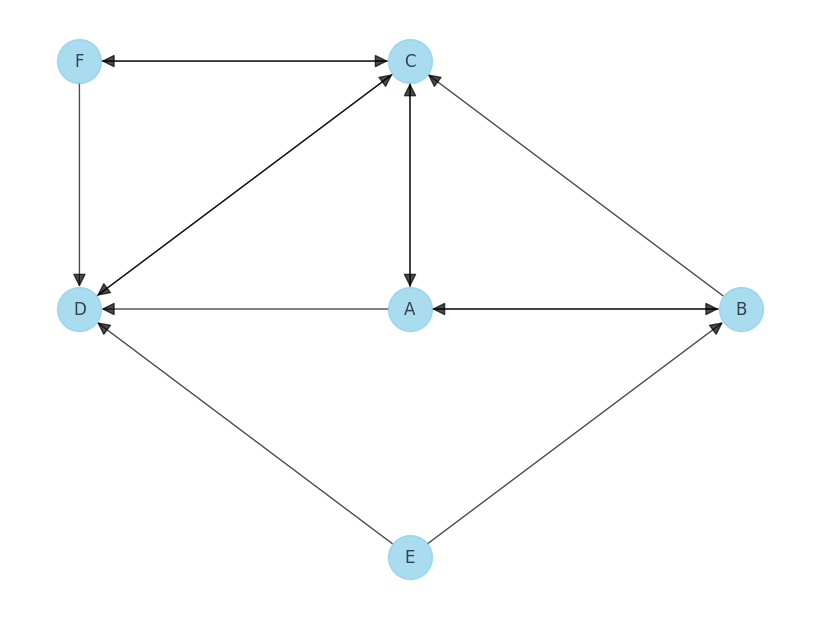

In [180]:
# Plot the graph
plt.rcParams['figure.figsize'] = 8, 6
pos = nx.spring_layout(graph, pos=fixed_positions, fixed = nodes)
nx.draw(graph, pos, arrows=True, with_labels=True, node_color='skyblue', alpha=0.7, 
        arrowsize=20, node_size=1000)

In case the code doesn't run properly because of package issues, it should generate the following image:

<img src="https://i.ibb.co/ftddfZ8/Graph1.jpg" alt="Graph1" border="0"></a>

Each web page is represented by a node labeled from `A` to `F`. We represent links by an ordered pair `(x,y)`, the first specifying the page containing the link and the second specifying the page to which it refers. In the picture, this is represented by an arrow that indicates which page links to which. The design principle of PageRank is that important websites will be linked **to** by other important websites. 

Now imagine 100 surfers on our micro-internet, each viewing a single website at a time. Every minute the surfers follow a random link on their website to another site. After a while, the websites that are most linked to will have more surfers visiting them, and in the long run, for every surfer that leaves a website each minute, another will enter keeping the total numbers of surfers on each website constant. This number of surfers at the end of this process (so in the equilibrium state) is what we will refer to as our ranking. 

We represent the number of surfers on each website at time $t$ by the column vector $x(t) = [x_A, x_B, x_C, x_D, x_E, x_F]$. The expected number of surfers at time $t+1$ is related to those at time $t$ via the transition matrix 
$$x(t+1) = Tx(t).$$
The **transition matrix** $T$ (also referred to as the hyperlink matrix) is in our situation a $6\times 6$ matrix defined by
$$T_{ij} = \begin{cases}
\frac{1}{L_j}, & \text{if page $j$ links to page $i$} \\
0, &\text{if page $j$ does not link to page $i$}
\end{cases}$$
where $L_j$ the number links on page $j$. We could say that $T$ takes the form
$$T = \begin{bmatrix}
p_{A \to A} & p_{B \to A}  & p_{C \to A}  & p_{D \to A} & p_{E \to A}  &  p_{F \to A}\\ 
p_{A \to B} & p_{B \to B}  & p_{C \to B}  & p_{D \to B} & p_{E \to B}  &  p_{F \to B}\\ 
p_{A \to C} & p_{B \to C}  & p_{C \to C}  & p_{D \to C} & p_{E \to C}  &  p_{F \to C}\\ 
p_{A \to D} & p_{B \to D}  & p_{C \to D}  & p_{D \to D} & p_{E \to D}  &  p_{F \to D}\\ 
p_{A \to E} & p_{B \to E}  & p_{C \to E}  & p_{D \to E} & p_{E \to E}  &  p_{F \to E}\\ 
p_{A \to F} & p_{B \to F}  & p_{C \to F}  & p_{D \to F} & p_{E \to F}  &  p_{F \to F}
\end{bmatrix},$$
where the columns represent the probability of leaving a website for any other website, and thus they sum to one. The rows determine how likely you are to enter a website from any other. 

## Problem 2: Transition matrix (2 points)

Define the transition matrix $T$ for our six page micro-internet example above as a NumPy array of shape $(6,6)$ and assign it to the variable `T`. 

In [181]:
# YOUR CODE HERE
n = len(nodes)
variants = 0
way = []
T = np.zeros((n, n), dtype=float)
i = 0
for start in nodes:
    variants = 0
    way = []
    j = 0
    for end in nodes:
        if  (start, end) in edges:
            variants += 1 
            way.append(j) 
        j += 1    
    for j in way:
            T[j,i] = 1/variants
        #print(i, coordinate)
    i += 1    
print(T)       

  

[[0.         0.5        0.33333333 0.         0.         0.        ]
 [0.33333333 0.         0.         0.         0.5        0.        ]
 [0.33333333 0.5        0.         1.         0.         0.5       ]
 [0.33333333 0.         0.33333333 0.         0.5        0.5       ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.33333333 0.         0.         0.        ]]


In [182]:
# You can use this code cell to play around with your code to make sure
# it does what it is intended to do, i.e. to debug your code. 


To test whether you haven't included any slight mistakes in your matrix $T$, we can check if the column values all add up to one, and you can check if you have the correct row sums. 

In [183]:
# Test case
print(np.sum(T, axis=0)) # column sums
print(np.sum(T, axis=1)) # row sums

[1. 1. 1. 1. 1. 1.]
[0.83333333 0.83333333 2.33333333 1.66666667 0.         0.33333333]


Expected output:

    [1. 1. 1. 1. 1. 1.]
    [0.83333333 0.83333333 2.33333333 1.66666667 0.         0.33333333]

In [184]:
# AUTOGRADING
assert np.allclose(np.sum(T, axis=0), 6*[1])
assert np.allclose(np.sum(T, axis=1), [5/6, 5/6, 7/3, 5/3, 0, 1/3])
assert np.allclose(T[0,0], 0)
assert np.allclose(T[2, 3], 1)
assert np.allclose(T[3, 5], 1/2)

## Power iteration method

The random process that describes the surfer's behavior is known as a *Markov chain*. Markov chains are widely applicable, well-studied, and have many remarkable and useful properties. It turns out, that under certain conditions (that are met by our given transition matrix), the probability distribution of finding a random surfer at a particular web page after $t$ iterations converges to a fixed equilibrium distribution. No matter where the surfer starts, the process eventually stabilizes to a point where further surfing provides no further information. This limiting probability is known as the page's rank, and tells us the likelihood of being at a particular page. 

To find this limiting distribution, suppose we start again with 100 surfers that are uniformly distributed over each of our 6 webpages, i.e. $x(0) = 100 * [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]$. We want to apply the matrix multiple times to find the distribution at time $t$:
$$x(t) = T^t x(0).$$
Suppose we keep multiplying by $T$ until we see very little change between the two vectors $x(t)$ and $x(t-1)$, that is, if
$$\| x(t) - x(t-1)\| \leq \varepsilon,$$
where $\varepsilon$ is some pre-defined tolerance. Once this condition is met, we expect further applications of $T$ will not change $x(t)$ very much and thus it serves as a signal to stop further iterations.

## Problem 3: Power iteration (2 points)

Implement the function `Pagerank_PI` below which computes $x(t)$ until $\|x(t) - x(t-1)\| \leq \text{tol}$. You can use the function `la.norm` to compute the norm of a vector.
*Hint: consider using a while-loop.*

In [212]:
def Pagerank_PI(T, tol):
    """
    Compute the limiting distribution x(t) of a transition matrix T,
    where we assume convergence when |x(t) - x(t-1)| <= tol. 
    
    Parameters
    ----------
        T (ndarray): n by n transition matrix whose columns add up to 1 
        tol (float): Tolerance for when to end iteration.
        
    Returns
    -------
        x (ndarray): Vector of limiting probability distribution (in percentages)
        i (int): Number of iterations required to achieve convergence
    
    """
    n,m = T.shape
    x = 100 * np.ones(n) / n 
    i = 0

    # YOUR CODE HERE
    while la.norm(T @ x - x) > tol:
        x = T @ x 
        i += 1
    i += 1 #since we also need to count that one itteration that became a limit
    x = T @ x

    return(x, i)

In [213]:
# You can use this code cell to play around with your code to make sure
# it does what it is intended to do, i.e. to debug your code. 
n,m = T.shape
x = 100 * np.ones(n) / n 
i = 0

tol=5

while abs(la.norm(T @ x) - la.norm(x)) > tol:
    x = T @ x
    i += 1
print(x, i)
    
# for i in range(57):   
#     print(abs(la.norm(T @ x) - la.norm(x)), i, abs(la.norm(T @ x) - la.norm(x)) <= tol)
#     x = T @ x
#print(la.norm(T @ x), la.norm(x))


[13.88888889 13.88888889 38.88888889 27.77777778  0.          5.55555556] 1


In [214]:
# Test case
# Convert given micro-internet graph to transition matrix
A = nx.convert_matrix.to_numpy_array(graph)
A = A.T
T1 = A / A.sum(axis=0)

tol = 10**(-10)
x, i = Pagerank_PI(T1, tol)
print("After", i, "iterations, the page distribution converged to \n", x)

After 57 iterations, the page distribution converged to 
 [16.          5.33333333 40.         25.33333333  0.         13.33333333]


Expected output:

    After 57 iterations, the page distribution converged to 
     [16.          5.33333333 40.         25.33333333  0.         13.33333333]
     
Based on these outcomes, we conclude that page C has the highest pagerank, followed by page D, and then in descending order pages A, F, B and E. Is this what you would have expected? Convince yourself that based on which pages seem important given which others link to them, that this is a sensible ranking. 

In [188]:
# AUTOGRADING
A = nx.convert_matrix.to_numpy_array(graph)
A = A.T
T1 = A / A.sum(axis=0)
x, i = Pagerank_PI(T1, 10**(-10))

assert np.allclose(x, [16, 16/3, 40, 76/3, 0, 40/3])
assert i == 57

## Eigenvectors and eigenvalues

We have discovered that the pageranks for our micro-internet are the probabilities in the limiting distribution of our transition matrix. We said that the long run behavior of this system is achieved when $x(t+1) = x(t)$. If we drop the time stamps, this allows us to write
$$Tx = x,$$
which is the eigenvalue equation for the matrix $T$ with eigenvalue 1. In other words, we are looking for an eigenvector that corresponds to an eigenvalue 1. The existence of such a vector is again guaranteed by the probabilistic structure of the matrix $T$. It turns out that for a transition matrix, all eigenvalues are less than 1 in absolute value, so we are interested in finding the eigenvector that belongs to the largest eigenvalue (this is also the reason why the power iteration method worked). We can use built-in methods to find the eigenvalues and eigenvectors of a given matrix.

## Problem 4: Eigenvectors (2 points)

Implement the function `Pagerank_eigen` below which computes the eigenvector corresponding to the eigenvalue 1 whose entries add up to 100%. 
*Hint: use the function `la.eig` which yields an array of eigenvalues and an array of eigenvectors. Sort the eigenvalues by their absolute value, and find the eigenvector that corresponds to the (largest) eigenvalue 1. Be aware that the eigenvalues given by `la.eig` are complex valued, you can use `np.real` to make arrays real-valued.*

In [189]:
def Pagerank_eigen(T):
    """
    Computes the eigenvector of T corresponding to eigenvalue 1,
    whose entries add up to 100. 
    
    Parameters
    ----------
        T (ndarray): n by n transition matrix whose columns add up to 1, and for
            which the diagonal entries are not equal to 1. 
            
    Returns
    -------
        x (ndarray): Eigenvector of T corresponding to eigenvalue 1,
            scaled such that its entries add up to 100.
            
    """
    
    eVals, eVecs = la.eig(T)
    
    # YOUR CODE HERE
    max_val = np.real(eVals[0])
    for i in range(eVals.size):
        if np.real(eVals[i]) >= max_val: 
            x = np.real(eVecs[:,i])
        coef = 100/sum(x)
        x = coef * x
    
    return(x)

In [190]:
# You can use this code cell to play around with your code to make sure
# it does what it is intended to do, i.e. to debug your code. 
eVals, eVecs = la.eig(T)
max_val = np.real(eVals[0])
for i in range(eVals.size):
    if eVals[i] >= max_val: 
        x = eVecs[:,i]    
coef = 100/sum(x)
x = coef * x


# eVals = np.sort(np.real(eVals))
# print("\n", np.real(eVals), "aaa", np.real(eVecs), "\n")

In [191]:
# Test case
x = Pagerank_eigen(T1)
print(x)

[16.          5.33333333 40.         25.33333333  0.         13.33333333]


Expected output:

    [16.          5.33333333 40.         25.33333333  0.         13.33333333]
    
Note that this is the same result as the one we had found using the power iteration method.

In [192]:
# AUTOGRADING
x = Pagerank_eigen(T1)
assert np.allclose(x, [16, 16/3, 40, 76/3, 0, 40/3])

## Damping parameter

The system we just studied converged fairly quickly to the correct answer. Let's consider an extension to our micro-internet where things start to go wrong. Say a new website G is added, see below: 

In [193]:
# Define the extended micro-internet as a graph.
# You don't have to understand this.
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
edges = [('A', 'B'),
         ('A', 'C'),
         ('A', 'D'), 
         ('B', 'A'), 
         ('B', 'C'),
         ('C', 'A'), 
         ('C', 'D'),
         ('C', 'F'),
         ('D', 'C'),
         ('E', 'B'),
         ('E', 'D'),
         ('F', 'C'),
         ('F', 'D'),
         ('B', 'G'),
         ('G', 'G')]

fixed_positions = {'A': (0, 0), 
                   'B': (1, 0),
                   'C': (0, 1),
                   'D': (-1, 0),
                   'E': (0, -1),
                   'F': (-1, 1),
                   'G': ((1, 1))}

graph2 = nx.DiGraph()
graph2.add_nodes_from(nodes)
graph2.add_edges_from(edges)

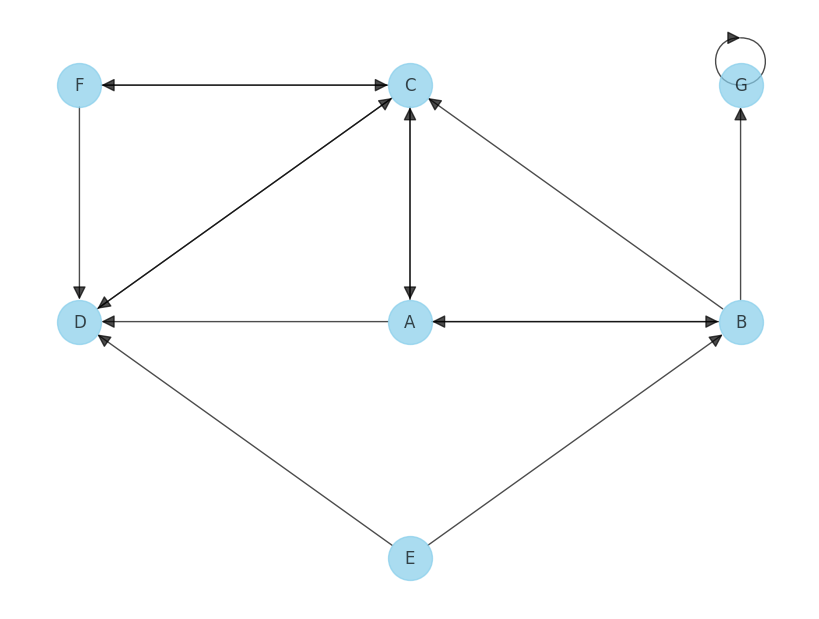

In [194]:
# Plot the graph
plt.rcParams['figure.figsize'] = 8, 6
pos = nx.spring_layout(graph2, pos=fixed_positions, fixed = nodes)
nx.draw(graph2, pos, arrows=True, with_labels=True, node_color='skyblue', alpha=0.7, 
        arrowsize=20, node_size=1000)
plt.savefig("Graph2.jpg", dpi=600, format="JPG")

In case the code doesn't run properly because of package issues, it should generate the following image:

<img src="https://i.ibb.co/9ZRYV26/Graph2.jpg" alt="Graph2" border="0"></a>

If we were to apply the power iteration method to this new model, the limiting distribution will converge to

    [0, 0, 0, 0, 0, 0, 100].
    
Page G will be taking all the traffic on the micro-internet, and somehow come at the top of the PageRank. This behavior can be understood, because once a surfer gets to page G, they can't leave, as all links head back to G. Eventually all surfers will end up on page G. 

To combat this, we can add a small probability that a surfer does not follow any link on a web page, but instead visits a website on the micro-internet at random. Let's assume the probability of following a link is $d$ and the probability of choosing a random website is therefore $1-d$. The new transition matrix now becomes
$$S = dT + \frac{1-d}{n} J,$$
where $T$ was our original transition matrix and $J$ is an $n \times n$ matrix where every element is one. 

If $d$ is one, we have the case we had previously, whereas if $d$ is zero, we will always visit a random page and therefore all webapges will be equally likely and equally ranked. For this extension to work best, $1-d$ should be somewhat small, but exactly how small we won't discuss any further. 

## Problem 5: Pagerank with dampening (2 points)

Implement the function `Pagerank_damped(T, d, tol)` that computes the pagerank vector with dampening factor $d$. 

In [217]:
def Pagerank_damped(T, d, tol):
    """
    Compute the limiting distribution x(t) of the transition matrix S = dT + (1-d)/n J,
    where J is a matrix with the same dimension as T and containing only ones,
    where we assume convergence when |x(t) - x(t-1)| <= tol. 
    
    Parameters
    ----------
        T (ndarray): n by n transition matrix whose columns add up to 1
        d (float): probability between 0 and 1 that signifies the likelihood of 
            following a link on the current page. 
        tol (float): Tolerance for when to end iteration.
        
    Returns
    -------
        x (ndarray): Vector of limiting probability distribution (in percentages)
        i (int): Number of iterations required to achieve convergence
    
    
    """
    
    # YOUR CODE HERE
    n, m = T.shape
    x = 100 * np.ones(n) / n
    i = 0
    
    J = np.ones((n,m))
    S = d*T + ((1-d)/n)*J
    while la.norm(S @ x - x) > tol:
        x = S @ x
        i += 1
    i += 1 # +1 itteration that became a limit
    x = S @ x 
    
    coef = 100/sum(x)
    x = coef * x
    return(x, i)
    

In [196]:
# You can use this code cell to play around with your code to make sure
# it does what it is intended to do, i.e. to debug your code. 

[2.82559362e-10 9.41864539e-11 7.06398404e-10 4.47385656e-10
 0.00000000e+00 2.35466135e-10] 240


C:\Users\Oksana\AppData\Local\Temp\ipykernel_16456\2761252815.py:4: RuntimeWarning: invalid value encountered in divide
  T1 = A / A.sum(axis=0)


In [218]:
# Test case
A = nx.convert_matrix.to_numpy_array(graph2)
A = A.T
T1 = A / A.sum(axis=0)

tol = 10**(-10)

# No dampening
d=1
x,i = Pagerank_damped(T1, d, tol)
print("Without dampening, after", i , "iterations, the page distribution converged to \n", x, "\n")

# With dampening
d = 0.9
x,i = Pagerank_damped(T1, d, tol)
print("With dampening, after", i , "iterations, the page distribution converged to \n", x)

Without dampening, after 1340 iterations, the page distribution converged to 
 [7.70276398e-10 2.61299393e-10 2.00937458e-09 1.28978097e-09
 0.00000000e+00 6.81636304e-10 1.00000000e+02] 

With dampening, after 192 iterations, the page distribution converged to 
 [10.78381727  5.30657375 25.87757906 17.20617779  1.42857143  9.19184515
 30.20543555]


Expected output:

    Without dampening, after 1340 iterations, the page distribution converged to 
     [7.70276398e-10 2.61299393e-10 2.00937458e-09 1.28978097e-09
     0.00000000e+00 6.81636304e-10 1.00000000e+02] 

    With dampening, after 192 iterations, the page distribution converged to 
     [10.78381727  5.30657375 25.87757906 17.20617779  1.42857143  9.19184515
     30.20543555]

In [219]:
# AUTOGRADING
A = nx.convert_matrix.to_numpy_array(graph2)
A = A.T
T1 = A / A.sum(axis=0)

tol = 10**(-10)

# No dampening
d=1
x,i = Pagerank_damped(T1, d, tol)
assert np.allclose(x, [0, 0, 0, 0, 0, 0, 100])
assert np.allclose(i, 1340)

# With dampening
d = 0.9
x,i = Pagerank_damped(T1, d, tol)
assert np.allclose(x, [10.78381727, 5.30657375, 25.87757906, 17.20617779, 1.42857143, 9.19184515, 30.20543555])
assert np.allclose(i, 192)